# Intro
Welcome to the [SIIM-FISABIO-RSNA COVID-19 Detection](https://www.kaggle.com/c/siim-covid19-detection/data) compedition.

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26680/logos/header.png)

For handling chest-x-ray data we recommend [this notebook](https://www.kaggle.com/drcapa/chest-x-ray-starter).

<span style="color: royalblue;">Please vote the notebook up if it helps you. Feel free to leave a comment above the notebook. Thank you. </span>

# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pydicom as dicom
import cv2
import ast

import warnings
warnings.filterwarnings("ignore")

# Path

In [2]:
path = '/kaggle/input/siim-covid19-detection/'
os.listdir(path)

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

# Load Data

In [3]:
train_image = pd.read_csv(path+'train_image_level.csv')
train_study = pd.read_csv(path+'train_study_level.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

# Overview

In [4]:
print('Number train images samples:', len(train_image))
print('Number train study samples:', len(train_study))
print('Number test samples:', len(samp_subm))

Number train images samples: 6334
Number train study samples: 6054
Number test samples: 2477


The train image-level metadata, with one row for each image, including both correct labels and any bounding boxes in a dictionary format.

In [5]:
train_image.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


The train study-level metadata, with one row for each study, including correct labels.

In [6]:
train_study.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


# Read DCM File
We consider the first train sample.

All images are stored in paths with the form **study/series/image**.

In [7]:
# Define image path of the example
path_train = path+'train/'+train_image.loc[0, 'StudyInstanceUID']+'/'+'81456c9c5423'+'/'
# Extract image name of the example
img_id = train_image.loc[0, 'id'].replace('_image', '.dcm')
# Load dicom file
data_file = dicom.dcmread(path_train+img_id)
# Extract image data of the dicom file
img = data_file.pixel_array

Print meta data of the image:

In [8]:
print(data_file)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.135099524260102611886915167296699866712
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 71228e4340de
(0008, 0018) SOP Instance UID                    UI: 000a312787f2
(0008, 0020) Study Date                          DA: '526316e376d4'
(0008, 0030) Study Time                          TM: '8ccfb6acf07f'
(0008, 0050) Accession Number                    SH: 'f6cd7f2019f5'
(0008, 0060) Modality                            CS: 'DX'
(0010, 0010) Patient's Name                      PN: 'd4268f26ed05'
(

Image shape:

In [9]:
print('Image shape:', img.shape)

Image shape: (3488, 4256)


Bounding Boxes:

In [10]:
boxes = ast.literal_eval(train_image.loc[0, 'boxes'])
boxes

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292},
 {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]

Plot the image of the chest-x-ray with the bounding boxes:

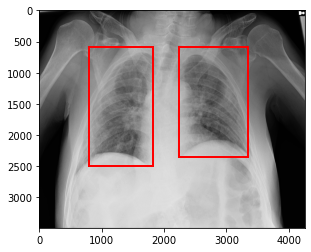

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))

for box in boxes:
    p = matplotlib.patches.Rectangle((box['x'], box['y']), box['width'], box['height'],
                                     ec='r', fc='none', lw=2.)
    ax.add_patch(p)
ax.imshow(img, cmap='gray')
plt.show()

# Show Examples
We plot some examples with the chest-x-ray image, the bounding boxes and the label:

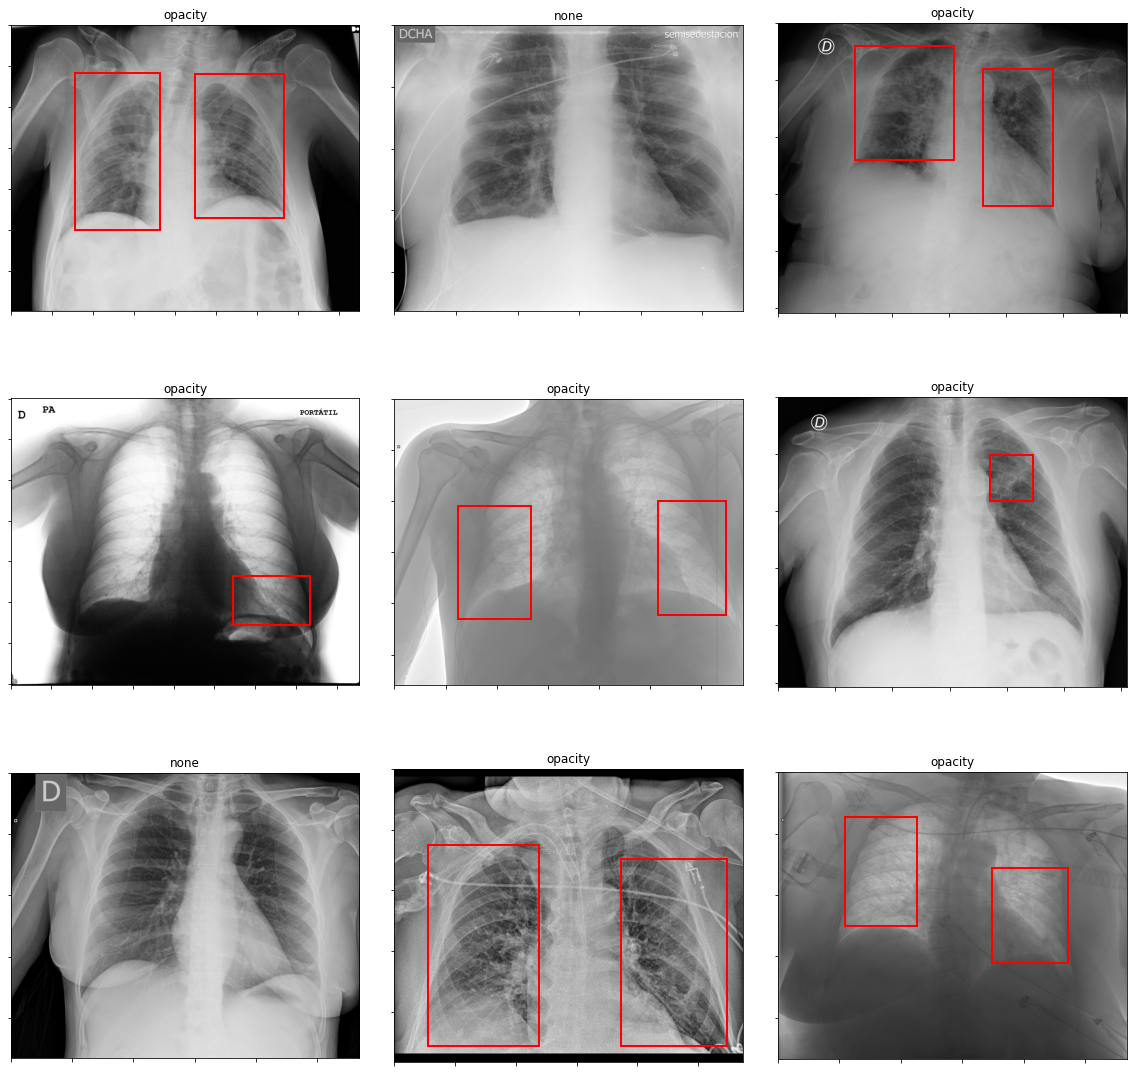

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
fig.subplots_adjust(hspace = .1, wspace=.1)
axs = axs.ravel()

for row in range(9):
    study = train_image.loc[row, 'StudyInstanceUID']
    path_in = path+'train/'+study+'/'
    folder = os.listdir(path_in)
    path_file = path_in+folder[0]
    filename = os.listdir(path_file)[0]
    file_id = filename.split('.')[0]
    
    data_file = dicom.dcmread(path_file+'/'+file_id+'.dcm')
    img = data_file.pixel_array
    if (train_image.loc[row, 'boxes']!=train_image.loc[row, 'boxes']) == False:
        boxes = ast.literal_eval(train_image.loc[row, 'boxes'])
    
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']), box['width'], box['height'],
                                     ec='r', fc='none', lw=2.)
            axs[row].add_patch(p)
    axs[row].imshow(img, cmap='gray')
    axs[row].set_title(train_image.loc[row, 'label'].split(' ')[0])
    axs[row].set_xticklabels([])
    axs[row].set_yticklabels([])

# Feature Engineering
There are 3 labels possible:
* none: no abnormalities on chest radiographs
* simple opacity: abnormalities on one side
* double opacity: abnormalities on both sides

So we can define 3 catgories:

In [13]:
label_dict = {0: 'none', 1: 'simple_opacity', 2: 'double_opacity'}

In [14]:
def split_label(s):
    split_string = s.split(' ')
    if len(split_string)==6 and 'none' in split_string:
        return 0
    elif len(split_string)==6 and 'opacity' in split_string:
        return 1
    else:
        return 2

In [15]:
train_image['category'] = train_image['label'].apply(split_label)

In [16]:
train_image.head()

,id,boxes,label,StudyInstanceUID,category
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,2
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,2
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,2


# EDA

We consider on the distribution of the three categories:

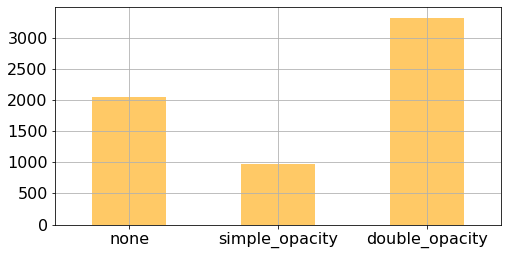

In [17]:
train_image['category'].value_counts().sort_index().rename(label_dict).plot.bar(rot=0, color='orange', alpha=0.6, grid=True, figsize=(8,4), fontsize=16)
plt.show()

Next we have a look on the study-level metadata:
* Negative for Pneumonia - 1 if the study is negative for pneumonia, 0 otherwise
* Typical Appearance - 1 if the study has this appearance, 0 otherwise
* Indeterminate Appearance  - 1 if the study has this appearance, 0 otherwise
* Atypical Appearance  - 1 if the study has this appearance, 0 otherwise

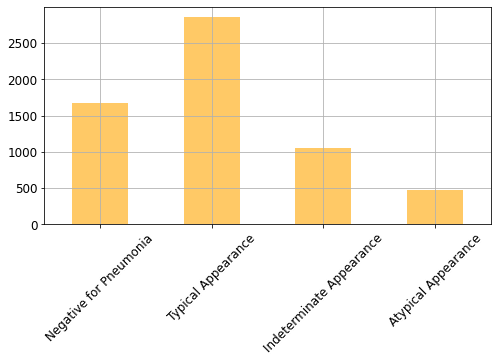

In [18]:
train_study.sum()[1:].plot.bar(rot=45, color='orange', alpha=0.6, grid=True, figsize=(8,4), fontsize=12)
plt.show()

# Data Generator
To load the data on demand we use a data generator.

*Coming soon*

# Export

In [19]:
samp_subm.to_csv('submission.csv', index=False)